# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chenshuzhou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chenshuzhou/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Loan Data use-case!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

In [6]:
len(docs)

269

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [7]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [8]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [9]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs[:20]:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 20, relationships: 0)

In [10]:
kg

KnowledgeGraph(nodes: 20, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [11]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/17 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/31 [00:00<?, ?it/s]

Property 'summary' already exists in node 'f856f7'. Skipping!
Property 'summary' already exists in node 'b2b7db'. Skipping!
Property 'summary' already exists in node 'd2de01'. Skipping!
Property 'summary' already exists in node 'b5a65e'. Skipping!
Property 'summary' already exists in node '40bda3'. Skipping!
Property 'summary' already exists in node '887ef0'. Skipping!
Property 'summary' already exists in node '9ce0a2'. Skipping!
Property 'summary' already exists in node '56e1f8'. Skipping!
Property 'summary' already exists in node '7b752b'. Skipping!
Property 'summary' already exists in node '2d679d'. Skipping!
Property 'summary' already exists in node '9b59ca'. Skipping!
Property 'summary' already exists in node '7300d8'. Skipping!
Property 'summary' already exists in node 'ee172c'. Skipping!
Property 'summary' already exists in node '395297'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/6 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/43 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'b2b7db'. Skipping!
Property 'summary_embedding' already exists in node '56e1f8'. Skipping!
Property 'summary_embedding' already exists in node 'b5a65e'. Skipping!
Property 'summary_embedding' already exists in node 'd2de01'. Skipping!
Property 'summary_embedding' already exists in node '40bda3'. Skipping!
Property 'summary_embedding' already exists in node '9b59ca'. Skipping!
Property 'summary_embedding' already exists in node 'f856f7'. Skipping!
Property 'summary_embedding' already exists in node '7b752b'. Skipping!
Property 'summary_embedding' already exists in node '887ef0'. Skipping!
Property 'summary_embedding' already exists in node '7300d8'. Skipping!
Property 'summary_embedding' already exists in node '9ce0a2'. Skipping!
Property 'summary_embedding' already exists in node '2d679d'. Skipping!
Property 'summary_embedding' already exists in node '395297'. Skipping!
Property 'summary_embedding' already exists in node 'ee172c'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 40, relationships: 478)

We can save and load our knowledge graphs as follows.

In [12]:
kg.save("loan_data_kg.json")
loan_data_kg = KnowledgeGraph.load("loan_data_kg.json")
loan_data_kg

KnowledgeGraph(nodes: 40, relationships: 478)

In [15]:
loan_data_kg.nodes[0].properties

{'page_content': 'Volume 3\nAcademic Calendars, Cost of Attendance, and\nPackaging\nIntroduction\nThis volume of the Federal Student Aid (FSA) Handbook discusses the academic calendar, payment period, and\ndisbursement requirements for awarding aid under the Title IV student financial aid programs, determining a student9s\ncost of attendance, and packaging Title IV aid.\nThroughout this volume of the Handbook, the words "we," "our," and "us" refer to the United States Department of\nEducation (the Department). The word "you" refers to the primary audience of the Handbook, school financial aid\nadministrators. In other volumes of the Handbook we use "institution," "school," and "college" interchangeably, unless a\nmore specific meaning is provided. In this volume we consistently use the term "school." <HEA= refers to the Higher\nEducation Act of 1965, as amended. Title IV refers to the student financial aid programs authorized under Title IV of the\nHEA.\nWe appreciate any comments that

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [16]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=loan_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [17]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


#### ✅ answer #1: 
- single hop specific query synthesizer :Creates simple, direct questions that can be answered from a single document/source.

- multi hop specific query synthesizer: Creates complex but factual questions that need multiple specific pieces of information

- multi hop abstract query synthesizer: Creates complex, conceptual questions that require combining information from multiple documents.

Finally, we can use our `TestSetGenerator` to generate our testset!

In [18]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,How does the definition of a 'Department' infl...,"[Chapter 1 Academic Years, Academic Calendars,...",The context does not explicitly define 'Depart...,single_hop_specifc_query_synthesizer
1,What does 34 CFR 668.3(b) specify regarding we...,[Regulatory Citations Academic year minimums: ...,34 CFR 668.3(b) pertains to weeks of instructi...,single_hop_specifc_query_synthesizer
2,What information does Volume 8 provide regardi...,[Inclusion of Clinical Work in a Standard Term...,Volume 8 states that clinical work conducted o...,single_hop_specifc_query_synthesizer
3,What are Non-Term Characteristics in programs ...,[Non-Term Characteristics A program that measu...,A program that measures progress in clock hour...,single_hop_specifc_query_synthesizer
4,What is Direct Loan how does it work?,[both the credit or clock hours and the weeks ...,The Direct Loan program involves disbursing fu...,single_hop_specifc_query_synthesizer
5,if the payment periods and installment schedul...,[<1-hop>\n\nboth the credit or clock hours and...,the first part explains that disbursement of f...,multi_hop_abstract_query_synthesizer
6,"How do the regulatory citations, such as 34 CF...","[<1-hop>\n\nChapter 1 Academic Years, Academic...",The regulatory citations 34 CFR 668.3(a) and 3...,multi_hop_abstract_query_synthesizer
7,How do the regulatory citations 34 CFR 668.3(a...,"[<1-hop>\n\nChapter 1 Academic Years, Academic...",The regulatory citations 34 CFR 668.3(a) and 3...,multi_hop_abstract_query_synthesizer
8,How do the definitions of academic years and i...,[<1-hop>\n\nboth the credit or clock hours and...,Volume 2 explains that the academic year for c...,multi_hop_specific_query_synthesizer
9,whats appendix A and B about in disbursement r...,[<1-hop>\n\nDisbursement Timing in Subscriptio...,Appendix B provides detailed guidance on disbu...,multi_hop_specific_query_synthesizer


In [20]:
# Save the testset dataframe to CSV
testset.to_pandas().to_csv('testset.csv')


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [24]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs[:20], testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/17 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/31 [00:00<?, ?it/s]

Property 'summary' already exists in node 'c1803d'. Skipping!
Property 'summary' already exists in node 'f8fed7'. Skipping!
Property 'summary' already exists in node 'bbf718'. Skipping!
Property 'summary' already exists in node 'e5f89d'. Skipping!
Property 'summary' already exists in node 'c2d72c'. Skipping!
Property 'summary' already exists in node 'd198f2'. Skipping!
Property 'summary' already exists in node '77c35a'. Skipping!
Property 'summary' already exists in node '8d10ae'. Skipping!
Property 'summary' already exists in node 'baeae8'. Skipping!
Property 'summary' already exists in node '1d6f37'. Skipping!
Property 'summary' already exists in node '8bbf56'. Skipping!
Property 'summary' already exists in node 'b0d238'. Skipping!
Property 'summary' already exists in node 'f2ed69'. Skipping!
Property 'summary' already exists in node 'faef0d'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/6 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/43 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'd198f2'. Skipping!
Property 'summary_embedding' already exists in node 'e5f89d'. Skipping!
Property 'summary_embedding' already exists in node 'f8fed7'. Skipping!
Property 'summary_embedding' already exists in node 'c1803d'. Skipping!
Property 'summary_embedding' already exists in node '1d6f37'. Skipping!
Property 'summary_embedding' already exists in node '8d10ae'. Skipping!
Property 'summary_embedding' already exists in node 'baeae8'. Skipping!
Property 'summary_embedding' already exists in node 'c2d72c'. Skipping!
Property 'summary_embedding' already exists in node 'bbf718'. Skipping!
Property 'summary_embedding' already exists in node 'f2ed69'. Skipping!
Property 'summary_embedding' already exists in node '77c35a'. Skipping!
Property 'summary_embedding' already exists in node '8bbf56'. Skipping!
Property 'summary_embedding' already exists in node 'b0d238'. Skipping!
Property 'summary_embedding' already exists in node 'faef0d'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [25]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What is the role of the School Participation D...,"[Chapter 1 Academic Years, Academic Calendars,...",The School Participation Division oversees com...,single_hop_specifc_query_synthesizer
1,What is 34 CFR 668.3(a) about in terms of acad...,[Regulatory Citations Academic year minimums: ...,Regulatory Citations Academic year minimums: 3...,single_hop_specifc_query_synthesizer
2,What is the significance of Chapter 3 in relat...,[Inclusion of Clinical Work in a Standard Term...,Inclusion of clinical work in a standard term ...,single_hop_specifc_query_synthesizer
3,What is the role of the Federal Work-Study pro...,[Non-Term Characteristics A program that measu...,The payment period is applicable to all Title ...,single_hop_specifc_query_synthesizer
4,How does inclusion of clinical work in standar...,[<1-hop>\n\nInclusion of Clinical Work in a St...,The inclusion of clinical work in standard ter...,multi_hop_abstract_query_synthesizer
5,How do the disbursement timing requirements fo...,[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing requirements for feder...,multi_hop_abstract_query_synthesizer
6,Considering the timing and scheduling constrai...,[<1-hop>\n\nInclusion of Clinical Work in a St...,The inclusion of clinical work in standard ter...,multi_hop_abstract_query_synthesizer
7,What guidance exists for including clinical wo...,[<1-hop>\n\nInclusion of Clinical Work in a St...,Inclusion of clinical work in loan periods is ...,multi_hop_abstract_query_synthesizer
8,How does Volume 8 explain the impact of accele...,[<1-hop>\n\nboth the credit or clock hours and...,Volume 8 details that for students in clock-ho...,multi_hop_specific_query_synthesizer
9,How does Volume 8 relate to disbursement timin...,[<1-hop>\n\nboth the credit or clock hours and...,Volume 8 discusses the impact of credit hours ...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

In [31]:
df = dataset.to_pandas()



# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [36]:
from langsmith import Client

client = Client()

dataset_name = "Loan Synthetic Data"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Loan Synthetic Data"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [37]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [38]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [39]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [40]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [41]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Loan RAG"
)

In [42]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [43]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [44]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [45]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [46]:
rag_chain.invoke({"question" : "What kinds of loans are available?"})

'Based on the provided context, the kinds of loans available include:\n\n- Direct Subsidized Loans  \n- Direct Unsubsidized Loans  \n- Direct PLUS Loans (including student Federal PLUS Loans and parent Direct PLUS Loans on behalf of dependent students)  \n- Federal Stafford Loans (Subsidized and Unsubsidized) made under the Federal Family Education Loan (FFEL) Program before July 1, 2010  \n- Federal SLS Loans  \n- Federal PLUS Loans made under the FFEL Program before July 1, 2010  \n\nNote that no new loans have been made under the FFEL Program since June 30, 2010.\n\nAdditionally:\n\n- Direct Subsidized Loans are available only to undergraduate students.  \n- Graduate or professional students are eligible only for Direct Unsubsidized Loans and Direct PLUS Loans, not Direct Subsidized Loans.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [47]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [48]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

empathy_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "empathy": "Is this response empathetic? Does it make the user feel like they are being heard?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `empathy_evaluator`:

#### ✅ answer - activity # 2
- `qa_evaluator`: Evaluates correctness/accuracy of the RAG system's answers. It compares the generated response against the reference answer to determine if the information provided is factually correct and complete.
- `labeled_helpfulness_evaluator`: Evaluates helpfulness of the response by comparing it to the reference answer. This measures whether the response actually assists the user in getting the information they need.
- `empathy_evaluator`: Evaluates the empathetic tone and emotional quality of responses. This measures the human-centered aspects of the response beyond just factual accuracy.

## LangSmith Evaluation

In [49]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'yellow-tray-98' at:
https://smith.langchain.com/o/9522861f-8e1e-4a62-8c0d-a84097b261bc/datasets/0e99c3c6-17a5-4795-9422-fe9ba5611d04/compare?selectedSessions=2330ce46-3447-4a08-8385-2a082f85c734




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does the inclusion of clinical work in sta...,"Based on the provided context, the inclusion o...",None,The inclusion of clinical work in standard ter...,0,0,0,5.617232,441f7a52-b2b1-41b0-9379-e865760221d4,aad61fe6-8512-4bba-abbe-56d14e81195c
1,How do the definitions of academic years in Ch...,The definitions of academic years in Chapter 1...,None,Chapter 1 explains that an academic year must ...,1,1,0,5.279635,db45609f-44a9-48ae-92c4-f266535a886c,448f1d05-e261-4f1f-8c90-e1d7ab200056
2,How does Volume 8 relate to disbursement timin...,"Volume 8, Chapter 6 is referenced as a source ...",None,Volume 8 discusses the impact of credit hours ...,1,0,0,2.576621,54c5504a-89d3-428d-8bcf-aafc8ba418e2,5d8b87ac-658a-4b23-a4f8-a4e49fff8e47
3,How does Volume 8 explain the impact of accele...,"Based on the provided context, Volume 8 discus...",None,Volume 8 details that for students in clock-ho...,0,0,0,7.317537,683f5c5e-d11b-4d6e-ad84-258f8de549be,a027c559-9d44-4a9f-a6c7-2579aa09249d
4,What guidance exists for including clinical wo...,I don't know.,None,Inclusion of clinical work in loan periods is ...,0,0,0,0.748351,95c882c1-d794-48c7-b37c-34f290080a56,0ba74dd7-a55b-4e59-b681-8690253323ec
5,Considering the timing and scheduling constrai...,"Based on the provided context, clinical work t...",None,The inclusion of clinical work in standard ter...,1,1,0,5.510211,3bacc0c1-7ccf-4cae-b766-0f5cb63091fd,5d93b174-aa52-4c13-87c0-0500b01aad39
6,How do the disbursement timing requirements fo...,Based on the provided context:\n\nFor **clock-...,None,The disbursement timing requirements for feder...,1,0,0,8.156542,3dfb4a55-2b6b-4c82-a300-68d199875d00,6e44d332-110b-4455-ac9f-537c63413de1
7,How does inclusion of clinical work in standar...,The context indicates that clinical work condu...,None,The inclusion of clinical work in standard ter...,1,1,0,4.399633,3f063f1b-4012-42d2-93d2-a95a4260605c,c451839a-ed2e-48c9-9edb-7096b8f638d9
8,What is the role of the Federal Work-Study pro...,The Federal Work-Study (FWS) Program is except...,None,The payment period is applicable to all Title ...,1,1,0,1.168516,a3539246-9dbe-4887-aaf2-9f9c652ded6e,2658191c-5468-456d-8244-1dd267604cc4
9,What is the significance of Chapter 3 in relat...,Chapter 3 provides additional guidance on cert...,None,Inclusion of clinical work in a standard term ...,1,0,0,1.726723,c950492e-2839-422e-ba8d-97d8d7aa022b,64942d11-a1de-4ba3-9a11-5dadaa079e57


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [ ]:
EMPATHY_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the question using empathy and kindness, and make sure the user feels heard.

Context: {context}
Question: {question}
"""

empathy_rag_prompt = ChatPromptTemplate.from_template(EMPATHY_RAG_PROMPT)

In [53]:
rag_documents = docs

In [55]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

#### ✅ answer #2
Increasing chunk size from 500 to 1000 characters improves RAG performance by providing more complete context per retrieval. Larger chunks preserve logical flow and keep related concepts together, reducing information fragmentation that often splits important details across multiple chunks. This leads to more comprehensive answers and fewer "I don't know" responses. For complex multi-hop questions, larger chunks are more likely to contain multiple related facts in one retrieval, reducing dependency on synthesizing fragmented information. The trade-off is better context quality versus potentially higher processing costs, but the improved completeness and accuracy make it worthwhile.

In [56]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

#### ✅ answer #3
Upgrading from text-embedding-3-small to text-embedding-3-large improves RAG performance through better semantic understanding. 
- The larger model has higher dimensionality (3072 vs 1536 dimensions) enabling more nuanced similarity matching and improved retrieval precision. 
- It better captures relationships between different terms (e.g., "financial aid" vs "student loans") and understands domain-specific terminology. This leads to more accurate document retrieval, especially for complex multi-hop questions requiring information synthesis. 
- The model reduces noise by retrieving semantically relevant chunks rather than just lexically similar ones. Trade-off: better accuracy versus higher cost and latency.

In [57]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Loan Data for RAG"
)

In [58]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [59]:
empathy_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | empathy_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [60]:
empathy_rag_chain.invoke({"question" : "What kinds of loans are available?"})

"Thank you for your question. Based on the context provided, there are several types of loans available to students and their parents to help cover educational costs:\n\n1. **Direct Subsidized Loans** – These loans are based on the student's financial need and can only be originated for that amount. They have a maximum eligibility amount linked to the student's cost of attendance minus other aid.\n\n2. **Direct Unsubsidized Loans** – These loans are available to both dependent and independent students and can cover unmet financial need as well as replace self-help aid (SAI). They are not based on financial need.\n\n3. **Direct PLUS Loans** – These loans are available to parents of dependent undergraduate students and to graduate or professional students themselves. Parents can borrow up to the student's cost of attendance minus other aid received. There is no fixed limit on the amount, but it cannot exceed the cost of attendance. PLUS loans require the parent borrower to meet eligibili

Finally, we can evaluate the new chain on the same test set!

In [61]:
evaluate(
    empathy_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "empathy_rag_chain"},
)

View the evaluation results for experiment: 'sparkling-print-48' at:
https://smith.langchain.com/o/9522861f-8e1e-4a62-8c0d-a84097b261bc/datasets/0e99c3c6-17a5-4795-9422-fe9ba5611d04/compare?selectedSessions=76e06d85-ba15-4913-932e-af5c75b51b07




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does the inclusion of clinical work in sta...,Thank you for your thoughtful question. Based ...,None,The inclusion of clinical work in standard ter...,0,0,1,5.428462,441f7a52-b2b1-41b0-9379-e865760221d4,ef6acba0-5655-4204-99ee-e978f2ed17c9
1,How do the definitions of academic years in Ch...,Thank you for your thoughtful question. Unders...,None,Chapter 1 explains that an academic year must ...,1,1,1,5.831749,db45609f-44a9-48ae-92c4-f266535a886c,bd09acef-dc06-4acc-9459-34a946c3c8c7
2,How does Volume 8 relate to disbursement timin...,Thank you for your thoughtful question. Based ...,None,Volume 8 discusses the impact of credit hours ...,0,0,1,4.059275,54c5504a-89d3-428d-8bcf-aafc8ba418e2,563092ab-d48c-4c10-875a-8f35bffd6bfc
3,How does Volume 8 explain the impact of accele...,Thank you for your thoughtful question. Based ...,None,Volume 8 details that for students in clock-ho...,0,0,1,5.542309,683f5c5e-d11b-4d6e-ad84-258f8de549be,5140e46f-ea89-46ac-9d7d-b6e8db09f168
4,What guidance exists for including clinical wo...,Thank you for your thoughtful question; I unde...,None,Inclusion of clinical work in loan periods is ...,1,0,1,2.590026,95c882c1-d794-48c7-b37c-34f290080a56,cf67ca98-6cf4-475a-96e2-5269ba548c6d
5,Considering the timing and scheduling constrai...,Thank you for your thoughtful question. I unde...,None,The inclusion of clinical work in standard ter...,1,0,1,6.058677,3bacc0c1-7ccf-4cae-b766-0f5cb63091fd,4822f110-1d12-480b-a0d1-510dcf6008f1
6,How do the disbursement timing requirements fo...,Thank you for your thoughtful question about s...,None,The disbursement timing requirements for feder...,1,1,1,10.809566,3dfb4a55-2b6b-4c82-a300-68d199875d00,a03a6b9e-9766-45cf-ae71-b88a3b5c2495
7,How does inclusion of clinical work in standar...,Thank you for your thoughtful question about h...,None,The inclusion of clinical work in standard ter...,1,1,1,3.664565,3f063f1b-4012-42d2-93d2-a95a4260605c,59f8a374-c797-454c-8284-0324997ce5bf
8,What is the role of the Federal Work-Study pro...,Thank you for your thoughtful question about t...,None,The payment period is applicable to all Title ...,1,1,1,5.020490,a3539246-9dbe-4887-aaf2-9f9c652ded6e,ddad14cd-f7f8-4f9a-9b69-13afbd3418ac
9,What is the significance of Chapter 3 in relat...,Thank you for your thoughtful question. Based ...,None,Inclusion of clinical work in a standard term ...,1,0,1,2.492904,c950492e-2839-422e-ba8d-97d8d7aa022b,ecb452c9-42f9-4e79-9a76-40fa7462aad7


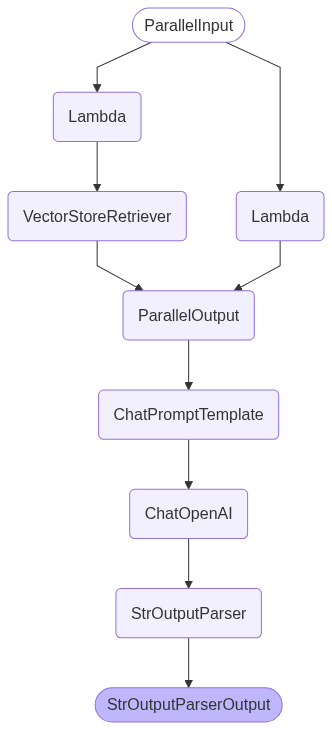

In [64]:
from IPython.display import Image, display
display(Image(empathy_rag_chain.get_graph().draw_mermaid_png()))

#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

![experiment](experiments.png)

- correctness: the two chains have the same correctness. Even if empathy_rag_chain using better model and bigger chunk size, the accuracy stays the same. 
- empathy: the "empathy_rag_chain" scores 100% on empathy while "rag_chain" scores 0%. This is because in the second chain's prompt, we explicitly ask it to "answer the question using empathy and kindness, and make sure the user feels heard". 
- helpfulness: "empathy_rag_chain" is slightly more helpful (0.5) than "rag_chain" (0.4). It could be due to the "empathy" requirement in the prompt, so the answer is longer and more detailed thus yielding in higher helpfulness score. 
- latency: "empathy_rag_chain" has higher latency than "rag_chain". In general, empthy chain has more output token. Again, could be due to the "empathy" requirement in its prompt. 